# Spatial and Identity Tandem VAE
Inspired by Olshausen and Cheung's work we try to segregate identity from spatial information in an unsupervised way

TODO:
- ~~Implement cross-covariance penalty~~
    - https://stackoverflow.com/questions/45874928/how-to-compute-covariance-in-tensorflow
    - https://arxiv.org/abs/1412.6583
    - https://en.wikipedia.org/wiki/Cross-covariance
    - ~~Needs to be per-batch basis, use regularization?~~ Just operate on the layer, it has shape [batch,dim]

In [50]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.layers import Dense,Input,Lambda,Concatenate,Activation
from keras.models import Model,load_model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback
from keras.losses import categorical_crossentropy,logcosh
import keras.backend as K
from keras.datasets import mnist

from tqdm import tqdm as tqdm

## Load train and test MNIST data from Keras

In [3]:
# (x_train, y_train,w_train), (x_test,y_test,w_test) = emnist.load_byclass()
(x_train, y_train), (x_test,y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
class_ids = np.unique(y_train)
masks_train = [y_train==i for i in class_ids]
masks_test = [y_test==i for i in class_ids]

digit_mask = lambda y: y<10 
uppercase = lambda y: (y>=10) & (y<36)
lowercase = lambda y: (y>=36) & (y<62)

input_shape=(784,)
print(x_train.shape)
print(x_test.shape)
# plt.imshow(x_train[masks[4]][10].reshape(28,28).T)

(60000, 784)
(10000, 784)


In [52]:
# Make dataset thats just a copy with random offsets
num_train = len(y_train)
num_test = len(y_test)

# pre-allocate shifted inputs
sx_train = np.empty((num_train,784*4))
sx_test = np.empty((num_test,784*4))

# pre-allocate list of dx,dy shifts for each image
delta_train = np.empty((num_train,2))
delta_test = np.empty((num_test,2))

def random_offset(X,scale=2):
    bg_size=(28*scale,28*scale)
    
    dx = int(np.random.normal(loc=0,scale=7))+14
    dy = int(np.random.normal(loc=0,scale=8.5))+14
    
    dx = max(dx,0)
    dx = min(dx,bg_size[0]-28)
    
    dy = max(dy,0)
    dy = min(dy,bg_size[0]-28)
#     print(dx,dy)
    new_im = np.zeros(bg_size)
    new_im[dx:dx+28,dy:dy+28] = letter
    
    return new_im,np.array([dx,dy])

print('making training data...')
for i in tqdm(np.arange(num_train)):
    letter = x_train[i].reshape(28,28)
    new_im,offsets = random_offset(letter,scale=2)
    sx_train[i] = new_im.reshape(1,4*784)
    delta_train[i] = offsets

print('making testing data...')
for i in tqdm(np.arange(num_test)):
    letter = x_test[i].reshape(28,28)
    new_im,offsets = random_offset(letter,scale=2)
    sx_test[i] = new_im.reshape(1,4*784)
    delta_test[i] = offsets

  5%|▍         | 2772/60000 [00:00<00:02, 27708.93it/s]

making training data...


 33%|███▎      | 3251/10000 [00:00<00:00, 32501.51it/s]

making testing data...


100%|██████████| 10000/10000 [00:00<00:00, 32683.64it/s]


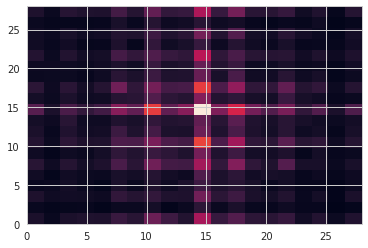

In [53]:
plt.hist2d(delta_test[:,0],delta_test[:,1],bins=20);

Example of a shifted digit on a larger background

3


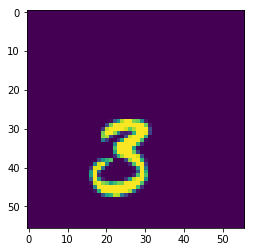

In [7]:
i = 250
print(y_train[masks_train[3]][i])
plt.imshow(sx_train[masks_train[3]][i].reshape(28*2,28*2))

In [8]:
def train_autoencoder(model,train,test,y_oh=False,mask=None,**kwargs):
    x_train,y_train = train
    x_test,y_test = test
    if y_oh:
        y_test = to_categorical(y_test,num_classes=10)
        y_train = to_categorical(y_train,num_classes=10)
        print(y_train.shape,y_test.shape)
        
    if mask is not None:
        X = x_train[mask(y_train)]
        V = (x_test[mask(y_test)],x_test[mask(y_test)])
    else:
        X = x_train
        V = (x_test,y_test)
    
    model.fit(X,y_train,validation_data=V,**kwargs)

## Define Model
```
|     Inputs (3136)     |
 \      h1 (1500)      /
  |     h2 (1500)     |
  
     |z_hat| |y_hat|
     
    /   h3 (1500)   \
   |    h4 (1500)    |
```   

In [54]:
encoding_dim = 1500
latent_dim = 2

# randomly shifted image
inputs = Input(shape=(784*4,))

encoded = build_dense(inputs,[1500,encoding_dim],activations='relu')

> dist_sample = sampler( args=(mean,std) )
>
>parameterizes a normal distribution from a mean and std and samples it

In [ ]:
def sampler(args):
    mean,log_stddev = args
    std_norm = K.random_normal(shape=(K.shape(mean)[0],latent_dim),mean=0,stddev=1)
    
    return mean + K.exp(log_stddev) * std_norm

In [10]:
z_mean = Dense(latent_dim,name='z_mean')(encoded)
z_log_sigma = Dense(latent_dim)(encoded)

# class prediction one-hot
y_hat = Dense(10,activation='softmax')(encoded)

# "layerize" z_hat random variable
lat_vec = Lambda(sampler,name='lat_sample')([z_mean,z_log_sigma])

# Concatenate with One-hot identity vector
combo_vec = Concatenate()([lat_vec,y_hat])

# Expand back out input dimensions (batch_size x im_size)

decoded_mean = build_dense(combo_vec,[1500,1500,4*784],activations=['relu','relu','sigmoid'])
tandem_vae = Model(inputs,decoded_mean)  

#### Combined Loss function

- Reconstruction loss (sum of squared error)

$ \sum\limits_{n} (X - \bar{X})^2 $
- Cross-covariance (XCov) of latent vars (z_hat, y_hat)
- Classification loss (categorical crossentropy)

In [12]:
def vae_loss(y_true,outputs):
    # Reconstruction loss
    reconstruction_loss = K.sum(K.square(inputs-decoded_mean),axis=-1)
#     kl_loss = -0.5*K.sum(1+z_log_sigma-K.square(z_mean)- K.square(K.exp(z_log_sigma)),axis=-1)
    XCov = 3*(0.5*K.sum(K.square(K.dot(K.transpose(y_hat-K.mean(y_hat,axis=0)),z_mean - K.mean(z_mean,axis=0),))))
    classification_loss = 6*categorical_crossentropy(y_true,y_hat)
    total_loss = K.mean(reconstruction_loss)+XCov+classification_loss
        
    return total_loss
# vae.compile(loss=vae_loss,optimizer='rmsprop')
tandem_vae.compile(loss=vae_loss,optimizer='adadelta')
# vae.summary()

## Train the model

In [14]:
train_autoencoder(tandem_vae,(sx_train, y_train),(sx_test,y_test),
#                   mask=uppercase,
                  y_oh=True,
                  shuffle=True,
                  epochs=15,
                  batch_size=128)

(60000, 3136) (60000, 784)
(10000, 3136) (10000, 784)
(60000, 10) (10000, 10)
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 9s 152us/step - loss: 211.7798 - val_loss: 150.2783
Epoch 2/15
60000/60000 [==============================] - 8s 133us/step - loss: 99.0799 - val_loss: 78.8252
Epoch 3/15
60000/60000 [==============================] - 8s 132us/step - loss: 73.5984 - val_loss: 70.1708
Epoch 4/15
60000/60000 [==============================] - 8s 134us/step - loss: 67.1080 - val_loss: 63.9768
Epoch 5/15
60000/60000 [==============================] - 8s 134us/step - loss: 61.7638 - val_loss: 57.8010
Epoch 6/15
60000/60000 [==============================] - 8s 133us/step - loss: 56.9213 - val_loss: 54.7274
Epoch 7/15
60000/60000 [==============================] - 8s 134us/step - loss: 53.2328 - val_loss: 52.4673
Epoch 8/15
60000/60000 [==============================] - 8s 134us/step - loss: 50.1748 - val_loss: 49.8874
Epoch 

## Extract/define helper models
- **Latent Encoder**
    - (Image -> z_hat)
    
    
- **Classifier**
    - (Image -> OH category)
    
    
- **Generator**
    - ([z_hat-y_hat] -> Image)
    
    

In [18]:
lat_encoder = Model(inputs,z_mean)
classifier = Model(inputs,y_hat)
decoder_inp = Input(shape=(10+latent_dim,))
dec_layers = tandem_vae.layers[-3:]
_gen_x = dec_layers[0](decoder_inp)
_gen_x = dec_layers[1](_gen_x)
outputs = dec_layers[2](_gen_x)
generator = Model(decoder_inp,outputs)

In [19]:
x_test_lat_enc = lat_encoder.predict(sx_test,batch_size=128)
x_test_class_enc = classifier.predict(sx_test,batch_size=128)

In [56]:
tandem_vae.save_weights('../models/tandem_vae/vae_weights.h5')
generator.save_weights('../models/tandem_vae/generator_weights.h5')
lat_encoder.save_weights('../models/tandem_vae/encoder.h5')

In [57]:
classifier.compile(loss='categorical_crossentropy',optimizer='adagrad',metrics=['accuracy'])
classifier_perf = classifier.evaluate(sx_test,to_categorical(y_test,num_classes=10))

print('Classification Accuracy: ',classifier_perf[1])

10000/10000 [==============================] - 1s 83us/step
Classification Accuracy:  0.6244


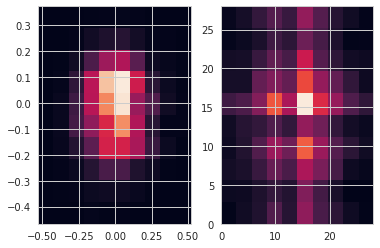

In [58]:
fig,axs = plt.subplots(1,2)

axs[0].hist2d(x_test_lat_enc[:,0],x_test_lat_enc[:,1],normed=True);
axs[1].hist2d(delta_test[:,0],delta_test[:,1],normed=True);
# plt.colorbar()

(10, 12)
[-0.04355137 -0.1034316 ]
[ 0.12684785 -0.21687838]
[-0.20623758 -0.07248245]
[-0.02002779 -0.11010043]
[ 0.11831427 -0.07657246]
[-0.12452502 -0.10493067]
[0.08822782 0.09978729]
[0.02918908 0.06986532]
[-0.11480596  0.09039332]
[ 0.14088017 -0.119196  ]


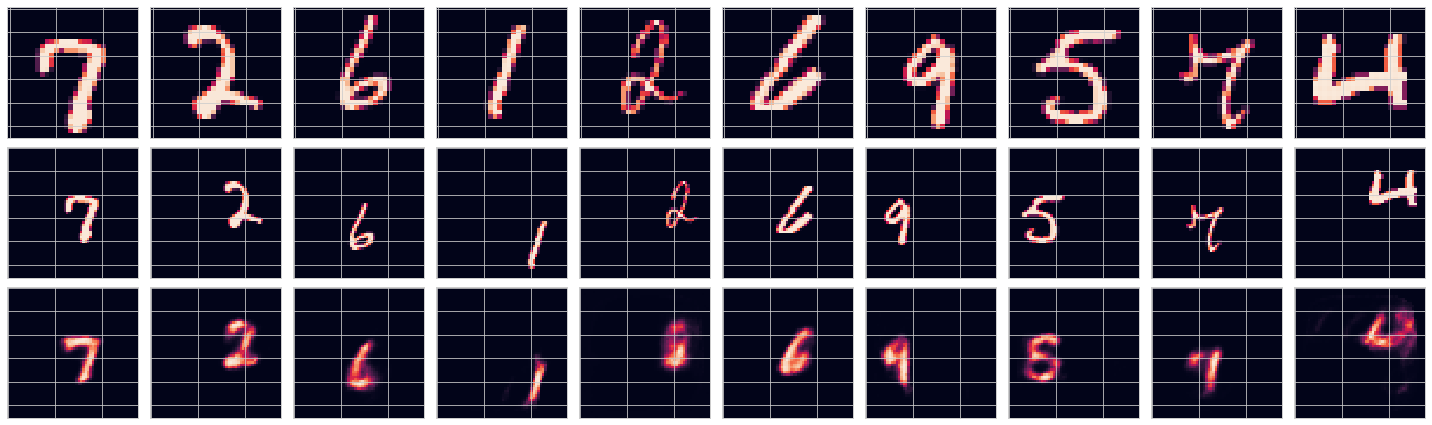

In [26]:
examples=10
sns.set_context('paper')
sns.set_style('whitegrid')
y_test_oh = to_categorical(y_test,num_classes=10)

z0_sigma = x_test_lat_enc[:,0].std()
z1_sigma = x_test_lat_enc[:,1].std()
# z2_sigma = x_test_lat_enc[:,2].std()

fig,axs = plt.subplots(3,examples,figsize=(20,6))
choices = np.random.choice(np.arange(len(y_test)),examples)
lat_vec_ = np.concatenate([x_test_lat_enc[choices],x_test_class_enc[choices]],axis=1)
print(lat_vec_.shape)
dec_test = generator.predict(lat_vec_)

# print(x_test_encoded[choices])

for i,idx in enumerate(choices):
    in_im = sx_test[idx].reshape(28*2,28*2)
    print(x_test_lat_enc[idx])
    dec_im = dec_test[i].reshape(28*2,28*2)
    rec_true_im = x_test[idx].reshape(28,28)
    
    axs[0,i].imshow(rec_true_im)
    axs[0,i].set_xticklabels([])
    axs[0,i].set_yticklabels([])
    axs[1,i].imshow(in_im)
    axs[1,i].set_xticklabels([])
    axs[1,i].set_yticklabels([])
    axs[2,i].imshow(dec_im)
    axs[2,i].set_xticklabels([])
    axs[2,i].set_yticklabels([])

plt.tight_layout()
# sns.despine(fig=fig)
# plt.imshow(dec_test[2].reshape(28,28).T)

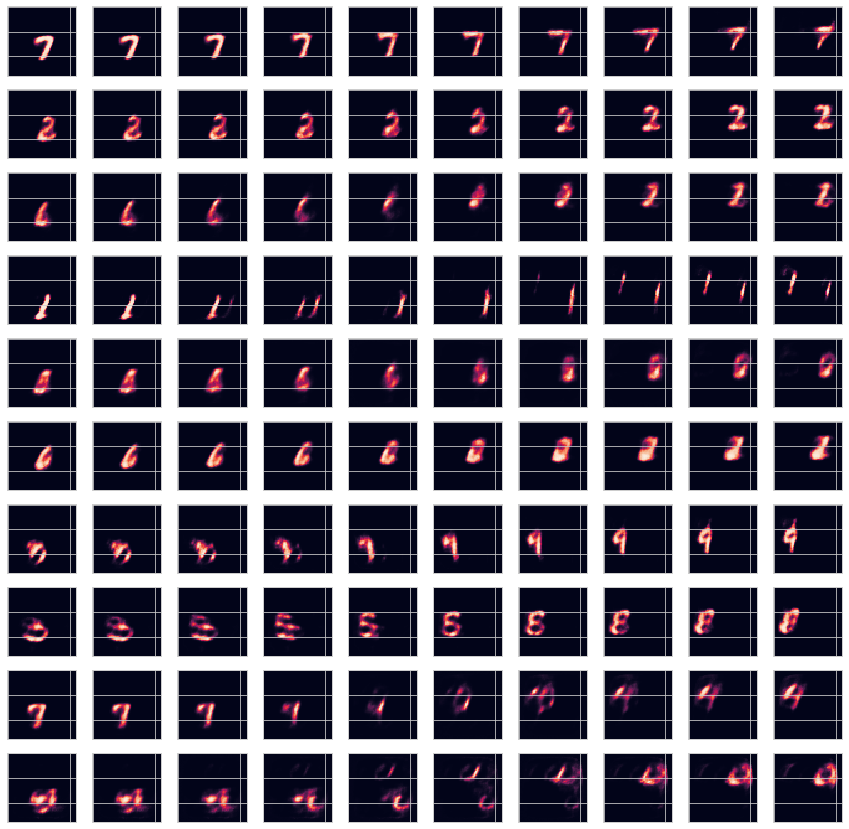

In [29]:
idx=2

all_sweeps = np.empty((10,10,4*784))

z0s = np.linspace(-2*z0_sigma,2*z0_sigma,num=10)
z1s = np.linspace(-2*z1_sigma,2*z1_sigma,num=10)
# z2s = np.linspace(-2*z2_sigma,2*z2_sigma,num=10)

fig,axs = plt.subplots(10,10,figsize=(15,15))

for j,vec in enumerate(lat_vec_):
    sweep = np.empty((10,12))
    for i,z in enumerate(z0s):
        sweep[i] = vec
        sweep[i,0] = z
    
    im_sweep = generator.predict(sweep)
    all_sweeps[j]=im_sweep
    
for i in np.arange(10):
    for j in np.arange(10):
        axs[i,j].imshow(all_sweeps[i,j].reshape(56,56))
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticklabels([])

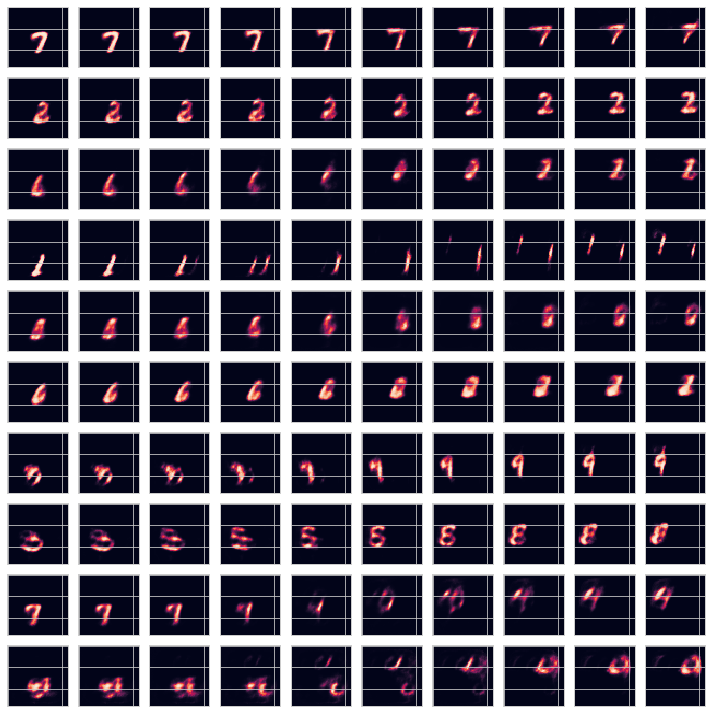

In [31]:
fig,axs = plt.subplots(10,10,figsize=(10,10))

for j,vec in enumerate(lat_vec_):
    sweep = np.empty((10,12))
    for i,z in enumerate(z0s):
        sweep[i] = vec
        sweep[i,0] = z
    
    im_sweep = generator.predict(sweep)
    all_sweeps[j]=im_sweep
    
for i in np.arange(10):
    for j in np.arange(10):
        axs[i,j].imshow(all_sweeps[i,j].reshape(56,56))
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticklabels([])
plt.tight_layout()

In [ ]:
fig,axs = plt.subplots(10,10,figsize=(10,10))

for j,vec in enumerate(lat_vec_):
    sweep = np.empty((10,13))
    for i,z in enumerate(z0s):
        sweep[i] = vec
        sweep[i,0] = z
    
    im_sweep = generator.predict(sweep)
    all_sweeps[j]=im_sweep
    
for i in np.arange(10):
    for j in np.arange(10):
        axs[i,j].imshow(all_sweeps[i,j].reshape(56,56))
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticklabels([])
plt.tight_layout()

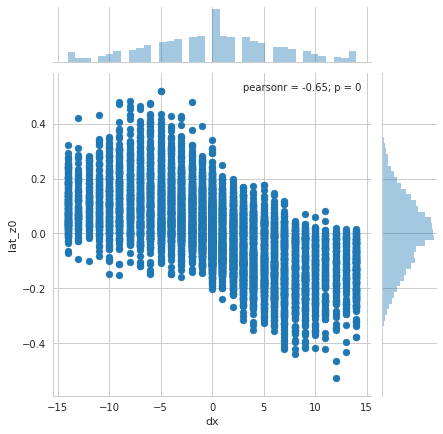

In [32]:
sns.set_context('notebook')
dxs = delta_test[:,0]
dys = delta_test[:,1]

g = sns.jointplot(dxs-14,x_test_lat_enc[:,0])
g.set_axis_labels(xlabel='dx',ylabel='lat_z0')


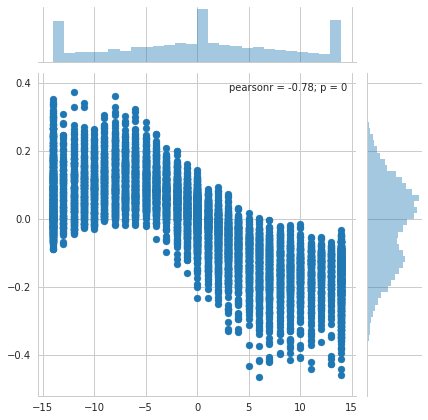

In [33]:
sns.jointplot(dys-14,x_test_lat_enc[:,1])

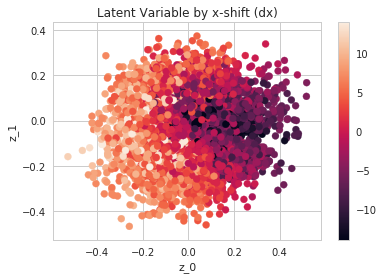

In [67]:
# fig,ax = plt.subplots(1,1,figsize=(5,5))
plt.scatter(x_test_lat_enc[:,0],x_test_lat_enc[:,1],c=dxs-14)
plt.xlabel('z_0')
plt.ylabel('z_1')
plt.title('Latent Variable by x-shift (dx)')

plt.colorbar()

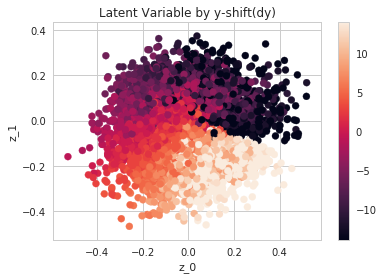

In [66]:
# fig,ax = plt.subplots(1,1,figsize=(5,5))
plt.scatter(x_test_lat_enc[:,0],x_test_lat_enc[:,1],c=dys-14)
plt.xlabel('z_0')
plt.ylabel('z_1')
plt.title('Latent Variable by y-shift (dy)')

plt.colorbar()

In [46]:
from sklearn.manifold import Isomap

iso = Isomap(n_neighbors=20,n_components=1)
lat_enc_iso = iso.fit_transform(X=x_test_lat_enc)

In [48]:
lat_enc_iso.shape

(10000, 1)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(x_test_loc_enc[:, 0], x_test_loc_enc[:, 1],
            c=y_test,alpha=0.5
           )
plt.colorbar()
plt.scatter(x=x_test_loc_enc[choices][:,0],y=x_test_loc_enc[choices][:,1],marker='+',
            s=20**2,color='k')
plt.show()

In [ ]:
import bqplot.pyplot as bqplt
from bqplot import Tooltip
import pandas as pd

recs = []
for i,cid in enumerate(y_test):
    recs.append(dict(
        loc_z=x_test_loc_enc[i],
        loc_z0=x_test_loc_enc[i][0],
        loc_z1=x_test_loc_enc[i][1],
        id_z=x_test_encoded[i],
        id_z0=x_test_encoded[i][0],
        id_z1=x_test_encoded[i][1],
        class_id=cid,
        dx=delta_test[i][0],
        dy=delta_test[i][1]
    ))
enc_df = pd.DataFrame.from_records(recs)
enc_df.head()  


In [ ]:
enc_df.to_pickle('./tandem_encoder_df.pk')
np.save('./sx_test.npy',sx_test)
np.save('./dec_test.npy',dec_test)

In [ ]:
# bqplt.figure(title='Autoencoder Latent Space')
# def_tt = Tooltip(fields=['x', 'y'], formats=['', '.2f'])
# bqplt.scatter(enc_df.loc_z0.values,enc_df.loc_z1.values)
# # plt.colorbar()
# bqplt.show()